In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import os
import math
import imageio

In [9]:
mux = 0.1 
muy = 0.05
def u0(x):
    return np.exp(-100*(x-0.2)**2) # gaussian wave
def u_true(x,t):
    return  u0(x - mu * t)

# 2D advection equation 
def u_2d_true(x, y, t):
        return u0(x - mux * t) * u0(y - muy * t)

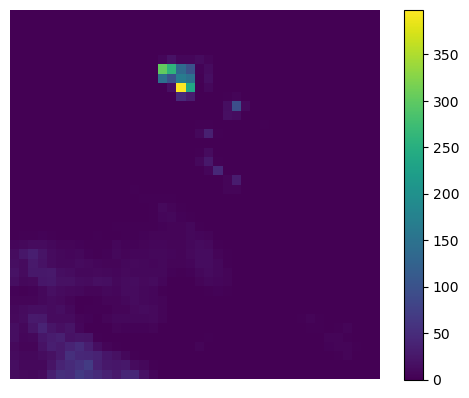

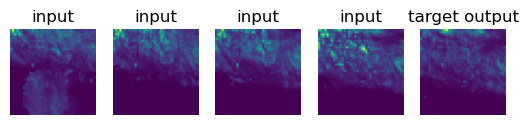

In [10]:
# load radar data
movies = np.load('data/radar_movies.npy')
movies.shape # (980, 40, 40, 20) -- here each movie is of length 20

# in our model we will use the first four images as inputs and predict the
# fifth image
x = movies[:, :, :,  :4]
y = movies[:, :, :, 4:5]


# function: animation of a sequence of radar data (shape = nx,ny,ntime)
def animate(x):
  fig, ax = plt.subplots()
  vmax = np.max(x)
  im = ax.imshow(x[:,:,0], vmin=0, vmax=vmax)
  fig.colorbar(im)
  plt.axis('off')
  def anim_(i):
      im.set_data(x[:,:,i])
      ax.set_title(str(i+1) + '/' + str(x.shape[2]))
  anim = animation.FuncAnimation(
      fig, anim_, interval=300, frames=x.shape[2], repeat_delay=1000)
  plt.show()

# i_plt = 340
# i_plt = 123
i_plt = np.int32(np.random.sample() * movies.shape[0])
animate(x[i_plt,:,:,:])
plt.show()

# train validate test split
tvt = np.tile(['train','train','train','validate','test'], y.shape[0])[:y.shape[0]]
x_train = x[np.where(tvt == 'train')]
y_train = y[np.where(tvt == 'train')]
x_validate = x[np.where(tvt == 'validate')]
y_validate = y[np.where(tvt == 'validate')]
x_test = x[np.where(tvt == 'test')]
y_test = y[np.where(tvt == 'test')]

n_test = x_test.shape[0]
i_plt = np.int32(np.random.sample() * n_test)
true = np.append(x_test[i_plt,:,:,:], y_test[i_plt,:,:,:], axis=2)
# plot an input/output pair
i_plt = 20
i_plt = np.int32(np.random.sample() * x_train.shape[0])
for jj in range(4):
  plt.subplot(1,5,jj+1)
  plt.imshow(x_train[i_plt,:,:,jj])
  plt.axis('off')
  plt.title('input')
plt.subplot(1,5,5)
plt.imshow(y_train[i_plt,:,:,0])
plt.title('target output')
plt.axis('off')
plt.show()

In [11]:
# xr = np.linspace(0,1,nx)
# yr = np.linspace(0,1,ny)
# tr = np.linspace(0,nt-1,nt).T
# # print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# # print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
# xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# # print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
# print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

# ur = u_2d_true(xrmesh,yrmesh,trmesh)

# #print(ur[:,:,0].shape)
# # print(ur[0,:,:].shape)
# # print(xrmesh[0,:,:].shape)
# #plot ur
# plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,0])
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Data at t=0')
# plt.colorbar()
# plt.show()

# # Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
# rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
# rin_data = torch.tensor(rin_data).float()
# rout_data = torch.tensor(ur).float().reshape(-1,1)

# rout_data2 = rout_data.numpy().reshape(nx,ny,nt)
# plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], rout_data2[:,:,0])
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title(' actual Data(torch) at t=0')
# plt.colorbar()
# plt.show()
# print(f'rin_data shape: {rin_data.shape} \n rout_data shape: {rout_data.shape}')

In [13]:
class FCN_iPINN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        # Initialize velocities as trainable parameters
        self.velocity_x = nn.Parameter(torch.tensor(1.0))
        self.velocity_y = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Initialize the PINN model
N_INPUT = 40 * 40 * 4  # Adjust the input size based on the shape of batch_x
N_OUTPUT = 40* 40
N_HIDDEN = 32
N_LAYERS = 3
pinn = FCN_iPINN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)



# Prepare the input and output data
x_train_tensor = torch.tensor(x_train).float()
y_train_tensor = torch.tensor(y_train).float()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create a TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create a DataLoader
batch_size = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Define the optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
mu_lr = 1e-1
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.reshape(batch_size, -1)  # Reshape batch_x to match the input size of the model
        batch_y = batch_y.reshape(batch_size, -1)  # Reshape to (batch_size*nx*ny, 1)
        if batch_x.shape[1] != N_INPUT:
            break
        optimizer.zero_grad()
        
        # Compute the "data loss"e
        uh = pinn(batch_x)
        #print(f'batch_x shape: {batch_x.shape} \n batch_y shape: {batch_y.shape}, output shape: {uh.shape}')
        loss1 = torch.mean((uh - batch_y)**2)  # Use mean squared error
        
        # Generate rin_physics based on the shape of batch_x
        nt_physics = 4  # Assuming nt = 4
        nx_physics, ny_physics = batch_x.shape[1] // nt_physics, batch_x.shape[1] // nt_physics
        xr_physics = torch.linspace(0, 1, nx_physics)
        yr_physics = torch.linspace(0, 1, ny_physics)
        tr_physics = torch.linspace(0, nt_physics-1, nt_physics)
        xr_mesh_physics, yr_mesh_physics, tr_mesh_physics = torch.meshgrid(xr_physics, yr_physics, tr_physics)
        rin_physics = torch.stack((xr_mesh_physics, yr_mesh_physics, tr_mesh_physics), dim=-1).reshape(-1, 3)
        
        rin_physics = torch.ones_like(batch_x, requires_grad=True)

        # Compute the "physics loss"
        uhp = pinn(rin_physics)
        grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics,
                                grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
        dudx = grad[:, 0]
        dudy = grad[:, 1]
        dudt = grad[:, 2]
        physics = dudt + pinn.velocity_x * dudx + pinn.velocity_y * dudy  # Advection equation
        loss2 = torch.mean((physics)**2)
        
        # Backpropagate combined loss
        loss = 2*loss1 + loss2  # Add two loss terms together
        dJdvx = torch.autograd.grad(loss, pinn.velocity_x, retain_graph=True, create_graph=True)[0]
        pinn.velocity_x.data = pinn.velocity_x.data - (mu_lr * dJdvx)
        dJdvy = torch.autograd.grad(loss, pinn.velocity_y, retain_graph=True, create_graph=True)[0]
        pinn.velocity_y.data = pinn.velocity_y.data - (mu_lr * dJdvy)
        loss.backward(retain_graph=True)
        optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        print("At iteration: ", epoch, "\n", "The current value of Vx is: ", pinn.velocity_x.item())
        print("At iteration: ", epoch, "\n", "The current value of Vy is: ", pinn.velocity_y.item())
        print(f' NN loss: {loss1.item()}, Physics loss: {loss2.item()}')

Epoch: 100/1000, Loss: 1835.7945556640625
At iteration:  99 
 The current value of Vx is:  0.9927403330802917
At iteration:  99 
 The current value of Vy is:  0.9918257594108582
 NN loss: 917.8972778320312, Physics loss: 0.0
Epoch: 200/1000, Loss: 1784.478271484375
At iteration:  199 
 The current value of Vx is:  0.9927402138710022
At iteration:  199 
 The current value of Vy is:  0.991825520992279
 NN loss: 892.2391357421875, Physics loss: 0.0
Epoch: 300/1000, Loss: 1758.0335693359375
At iteration:  299 
 The current value of Vx is:  0.8981042504310608
At iteration:  299 
 The current value of Vy is:  0.9723264575004578
 NN loss: 879.0166625976562, Physics loss: 0.00023786487872712314
Epoch: 400/1000, Loss: 1732.335205078125
At iteration:  399 
 The current value of Vx is:  0.9004907011985779
At iteration:  399 
 The current value of Vy is:  0.9157923460006714
 NN loss: 866.1676025390625, Physics loss: 0.0
Epoch: 500/1000, Loss: 1718.674560546875
At iteration:  499 
 The current valu

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import imageio

def create_gif(frames, output_path, duration=0.1):
    imageio.mimsave(output_path, frames, duration=duration)

def animate2(x1, x2, i_plt, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    vmax = np.max(np.append(x1, x2))
    vmin = np.min(np.append(x1, x2))
    
    frames = min(x1.shape[2], x2.shape[2])  # Get the minimum number of frames
    
    # Initialize lists to store MAE and RMSE for each frame
    mae_list = []
    rmse_list = []
    
    # Initialize lists to store the frames for creating GIFs
    pred_frames = []
    true_frames = []
    
    for i in range(frames):
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed
        
        im1 = ax[0].imshow(x1[:, :, i], vmin=vmin, vmax=vmax)
        im2 = ax[1].imshow(x2[:, :, i], vmin=vmin, vmax=vmax)
        
        diff = x1[:, :, i] - x2[:, :, i]
        vmin_diff, vmax_diff = np.min(diff), np.max(diff)
        norm = mcolors.Normalize(vmin=vmin_diff, vmax=vmax_diff)
        im3 = ax[2].imshow(diff, cmap='viridis', norm=norm)
        
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im3, cax=cbar_ax)
        
        # Add labels
        ax[0].set_title('Predicted')
        ax[1].set_title('True')
        ax[2].set_title('Difference')
        
        # Remove axis ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        
        # Calculate MAE and RMSE for the current frame
        mae = np.mean(np.abs(diff))
        rmse = np.sqrt(np.mean(diff ** 2))
        
        # Append MAE and RMSE to the lists
        mae_list.append(mae)
        rmse_list.append(rmse)
        
        # Add MAE and RMSE to the plot title
        fig.suptitle(f'Physics informed NN | i = {i_plt} Predict Frame - MAE: {mae:.4f}, RMSE: {rmse:.4f}', fontsize=12)
        
        # Save the current frame as an image file
        filename = f'PiNNframe_{i_plt:04d}_{i+1:04d}.png'
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)
        
        # Append the current frame to the respective lists for creating GIFs
        pred_frames.append(x1[:, :, i])
        true_frames.append(x2[:, :, i])
    
    # Create and save the GIFs
    pred_gif_path = os.path.join(output_folder, f'pred_{i_plt:04d}.gif')
    true_gif_path = os.path.join(output_folder, f'true_{i_plt:04d}.gif')
    create_gif(pred_frames, pred_gif_path)
    create_gif(true_frames, true_gif_path)

# Testing loop
test_loss = 0.0
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

with torch.no_grad():
    for i_plt, (batch_x, batch_y) in enumerate(test_loader):
        print(f'batch_x shape: {batch_x.shape}\nbatch_y shape: {batch_y.shape}')
        batch_x = batch_x.reshape(batch_x.size(0), -1)
        batch_y = batch_y.reshape(batch_y.size(0), -1)  # Reshape batch_x to match the input size of the model
        
        if batch_x.shape[1] != N_INPUT:
            break
        
        # Forward pass
        output = pinn(batch_x)
        print(f'output shape: {output.shape}')
        
        # Compute data loss
        data_loss = criterion(output, batch_y)
        
        # Combine losses
        loss = data_loss
        
        test_loss += loss.item() * batch_x.size(0)
        
        # Plot the results for the current batch
        for j in range(batch_x.size(0)):
            print(f'Batch {i_plt}, Sample {j}, batch_x.shape: {batch_x[j].shape}, batch_y.shape: {batch_y[j].shape}, output.shape: {output[j].shape}')
            true = np.concatenate((batch_x[j].cpu().numpy().reshape(40, 40, 4), batch_y[j].cpu().numpy().reshape(40, 40, 1)), axis=2)
            pred = np.concatenate((batch_x[j].cpu().numpy().reshape(40, 40, 4), output[j].cpu().numpy().reshape(40, 40, 1)), axis=2)
            anim = animate2(pred, true, i_plt * batch_x.size(0) + j, '/home/sushen/PhysNet-RadarNowcast/2d-advection/nn_plot')

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader.dataset)
print(f'Average Test Loss: {avg_test_loss:.4f}')

batch_x shape: torch.Size([196, 40, 40, 4])
batch_y shape: torch.Size([196, 40, 40, 1])
output shape: torch.Size([196, 1600])
Batch 0, Sample 0, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 1, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 2, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 3, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 4, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 5, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 6, batch_x.shape: torch.Size([6400]), batch_y.shape: torch.Size([1600]), output.shape: torch.Size([1600])
Batch 0, Sample 7, b